# 09.1a: The Quantum of Separation in bfloat16

**Rigorous calculation of the distinguishability threshold for Qwen 3 4B vectors**

When we say two tokens are "quantization-indistinguishable" in bfloat16, we mean their vectors cannot be told apart given the finite precision of the bfloat16 format. This notebook establishes the rigorous mathematical foundation for that claim.

## Background

**bfloat16 format:**
- 1 sign bit
- 8 exponent bits (same as float32)
- 7 mantissa bits (vs 23 in float32)

**Unit in Last Place (ULP):**
For a number with exponent $e$, the spacing between representable values is:

$$\text{ULP} = 2^{e - 7}$$

where 7 comes from the mantissa bits.

**Distinguishability threshold:**
Two vectors are distinguishable if they differ by more than $2 \times \text{ULP}$ in at least one component (Chebyshev distance).

Why $2 \times \text{ULP}$? Because quantization rounds to nearest representable value. If two values are within $1 \times \text{ULP}$, they might round to the same representable value. At $2 \times \text{ULP}$, they're guaranteed to land in different quantization bins.

## Goal

1. Demonstrate ULP calculation at different scales
2. Measure the actual scale of Qwen 3 4B embedding components
3. Compute the rigorous distinguishability threshold for this model
4. Validate against known black hole structure

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Gamma matrix (centered)
GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

# Black holes (if we have them saved)
BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# bfloat16 parameters
BFLOAT16_MANTISSA_BITS = 7
DISTINGUISHABILITY_MULTIPLIER = 2.0  # 2× ULP threshold

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Part 1: bfloat16 ULP Mechanics

First, let's implement the ULP calculation and demonstrate it at various scales.

In [3]:
def bfloat16_ulp(x):
    """
    Compute bfloat16 ULP (Unit in Last Place) for scalar value x.
    
    For normalized numbers: ULP = 2^(exponent - 7)
    For subnormals (very small): use minimum exponent
    
    Args:
        x: scalar value (float)
    
    Returns:
        ULP spacing at scale of x
    """
    x = abs(x)
    
    if x == 0:
        # Minimum subnormal spacing
        return 2.0 ** (-126 - BFLOAT16_MANTISSA_BITS)
    
    # Find exponent: floor(log2(|x|))
    exponent = int(np.floor(np.log2(x)))
    
    # ULP at this exponent
    ulp = 2.0 ** (exponent - BFLOAT16_MANTISSA_BITS)
    
    return ulp

print("✓ ULP function defined")

✓ ULP function defined


### ULP at Various Scales

Let's compute ULP at scales relevant to neural network embeddings:

In [4]:
print("bfloat16 ULP at various scales:\n")
print("Value      Exponent    ULP           2×ULP (threshold)")
print("="*70)

test_values = [1.0, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]

for val in test_values:
    ulp = bfloat16_ulp(val)
    threshold = DISTINGUISHABILITY_MULTIPLIER * ulp
    exponent = int(np.floor(np.log2(val)))
    
    print(f"{val:10.5f}  {exponent:4d}        {ulp:.6e}    {threshold:.6e}")

print("\n✓ ULP demonstration complete")

bfloat16 ULP at various scales:

Value      Exponent    ULP           2×ULP (threshold)
   1.00000     0        7.812500e-03    1.562500e-02
   0.50000    -1        3.906250e-03    7.812500e-03
   0.10000    -4        4.882812e-04    9.765625e-04
   0.01000    -7        6.103516e-05    1.220703e-04
   0.00100   -10        7.629395e-06    1.525879e-05
   0.00010   -14        4.768372e-07    9.536743e-07
   0.00001   -17        5.960464e-08    1.192093e-07

✓ ULP demonstration complete


## Part 2: Load Qwen 3 4B Gamma Matrix

In [5]:
data_dir = Path(TENSOR_DIR)

print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]

N, d = gamma.shape
print(f"  Shape: ({N:,}, {d:,})")
print(f"  Dtype: {gamma.dtype}")
print(f"  Device: {gamma.device}")
print(f"\n✓ Gamma matrix loaded")

Loading gamma matrix...
  Shape: (151,936, 2,560)
  Dtype: torch.float32
  Device: cpu

✓ Gamma matrix loaded


## Part 3: Measure Component-wise Scales

What's the typical magnitude of components in the gamma matrix? This tells us what ULP scale to expect.

In [7]:
print("Computing component-wise statistics...\n")

# Component-wise absolute values
gamma_abs = gamma.abs()

# Global statistics
print("Global component magnitude statistics:")
print(f"  Min (non-zero): {gamma_abs[gamma_abs > 0].min().item():.6e}")
print(f"  Max:            {gamma_abs.max().item():.6e}")
print(f"  Mean:           {gamma_abs.mean().item():.6e}")
print(f"  Median:         {gamma_abs.median().item():.6e}")
print(f"  Std:            {gamma_abs.std().item():.6e}")

# Percentiles (sample for efficiency - 388M values is too large for quantile)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
sample_size = min(10_000_000, gamma_abs.numel())
gamma_abs_flat = gamma_abs.flatten()
indices = torch.randperm(gamma_abs_flat.numel())[:sample_size]
sample = gamma_abs_flat[indices]

print(f"\nPercentiles (sampled {sample_size:,} values):")
for p in percentiles:
    val = torch.quantile(sample, p / 100.0).item()
    print(f"  {p:2d}%: {val:.6e}")

print("\n✓ Component statistics computed")

Computing component-wise statistics...

Global component magnitude statistics:
  Min (non-zero): 1.396984e-09
  Max:            2.177292e-01
  Mean:           1.640665e-02
  Median:         1.357036e-02
  Std:            1.293724e-02

Percentiles (sampled 10,000,000 values):
   1%: 2.276758e-04
   5%: 1.141352e-03
  10%: 2.307069e-03
  25%: 6.121551e-03
  50%: 1.357273e-02
  75%: 2.377018e-02
  90%: 3.454483e-02
  95%: 4.150847e-02
  99%: 5.537503e-02

✓ Component statistics computed


### Component Magnitude Histogram

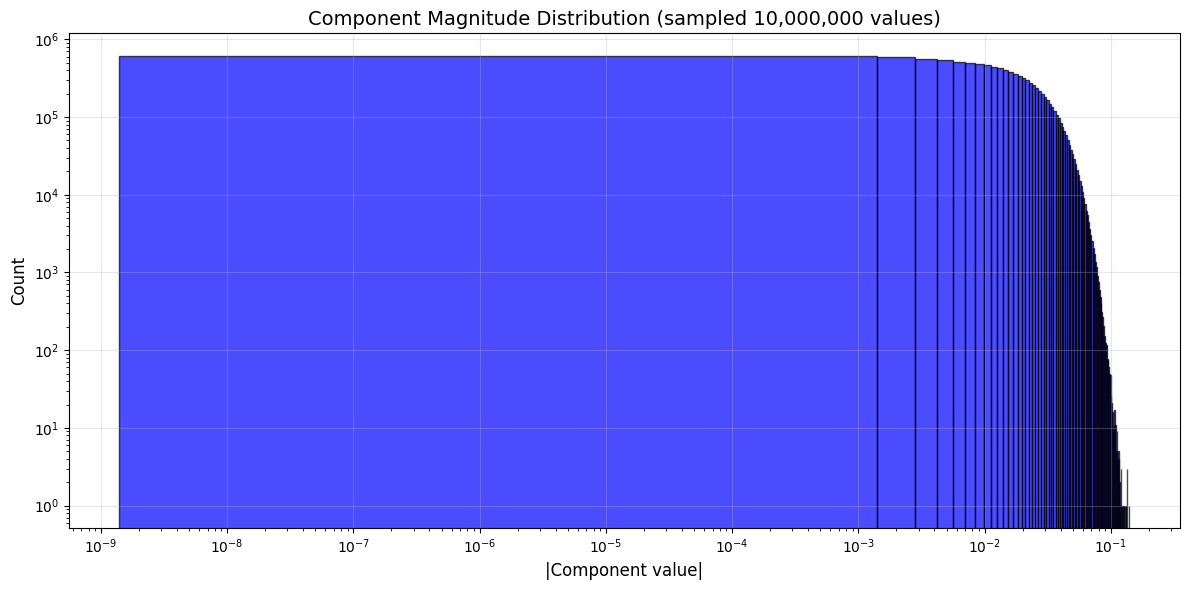

✓ Component magnitude histogram plotted


In [8]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

# Sample for histogram (all 151k × 2560 = 388M values is too much)
sample_size = min(10_000_000, gamma_abs.numel())
gamma_abs_flat = gamma_abs.flatten()
indices = torch.randperm(gamma_abs_flat.numel())[:sample_size]
sample = gamma_abs_flat[indices]

# Histogram on log scale
ax.hist(sample.cpu().numpy(), bins=100, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('|Component value|', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Component Magnitude Distribution (sampled {sample_size:,} values)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Component magnitude histogram plotted")

## Part 4: Black Hole Region Analysis

Now let's focus on the black hole region specifically. We know from previous work (07.3h) that black holes exist. Let's load them and measure their scale.

In [9]:
print("Loading black hole mask...")

try:
    bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
    black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
    n_bh = black_hole_mask.sum().item()
    print(f"  Black holes: {n_bh:,} tokens")
    
    # Extract black hole vectors
    bh_vectors = gamma[black_hole_mask]
    print(f"  Shape: {bh_vectors.shape}")
    
    have_black_holes = True
    
except FileNotFoundError:
    print(f"  Black hole mask not found at {data_dir / BLACK_HOLE_MASK_FILE}")
    print(f"  Will analyze global statistics only")
    have_black_holes = False

print("\n✓ Black hole data loaded" if have_black_holes else "\n⚠ Proceeding without black hole data")

Loading black hole mask...
  Black holes: 2,100 tokens
  Shape: torch.Size([2100, 2560])

✓ Black hole data loaded


### Black Hole Component Scale

In [10]:
if have_black_holes:
    print("Black hole component magnitude statistics:\n")
    
    bh_abs = bh_vectors.abs()
    
    print(f"  Min (non-zero): {bh_abs[bh_abs > 0].min().item():.6e}")
    print(f"  Max:            {bh_abs.max().item():.6e}")
    print(f"  Mean:           {bh_abs.mean().item():.6e}")
    print(f"  Median:         {bh_abs.median().item():.6e}")
    print(f"  Std:            {bh_abs.std().item():.6e}")
    
    # Typical magnitude for ULP calculation
    typical_magnitude = bh_abs.mean().item()
    
    print(f"\nUsing mean magnitude for ULP calculation: {typical_magnitude:.6e}")
    print("\n✓ Black hole scale measured")
else:
    print("Using global mean magnitude for ULP calculation")
    typical_magnitude = gamma_abs.mean().item()
    print(f"  Typical magnitude: {typical_magnitude:.6e}")

Black hole component magnitude statistics:

  Min (non-zero): 2.027955e-06
  Max:            3.293261e-02
  Mean:           2.361163e-03
  Median:         1.877725e-03
  Std:            2.279666e-03

Using mean magnitude for ULP calculation: 2.361163e-03

✓ Black hole scale measured


## Part 5: Compute Rigorous Distinguishability Threshold

Now we compute the ULP at the scale of our vectors and define the rigorous threshold.

In [11]:
print("Computing distinguishability threshold:\n")

ulp = bfloat16_ulp(typical_magnitude)
threshold = DISTINGUISHABILITY_MULTIPLIER * ulp

print(f"Typical component magnitude:  {typical_magnitude:.6e}")
print(f"Exponent:                     {int(np.floor(np.log2(typical_magnitude)))}")
print(f"ULP at this scale:            {ulp:.6e}")
print(f"")
print(f"Distinguishability threshold: {threshold:.6e}")
print(f"  (= {DISTINGUISHABILITY_MULTIPLIER:.1f} × ULP)")
print(f"")
print(f"Two vectors are DISTINGUISHABLE if:")
print(f"  max_i |u_i - v_i| > {threshold:.6e}")
print(f"")
print(f"Two vectors are INDISTINGUISHABLE if:")
print(f"  max_i |u_i - v_i| ≤ {threshold:.6e}")

print("\n✓ Distinguishability threshold computed")

Computing distinguishability threshold:

Typical component magnitude:  2.361163e-03
Exponent:                     -9
ULP at this scale:            1.525879e-05

Distinguishability threshold: 3.051758e-05
  (= 2.0 × ULP)

Two vectors are DISTINGUISHABLE if:
  max_i |u_i - v_i| > 3.051758e-05

Two vectors are INDISTINGUISHABLE if:
  max_i |u_i - v_i| ≤ 3.051758e-05

✓ Distinguishability threshold computed


## Part 6: Validate Against Black Holes

If we have black hole data, let's validate this threshold by checking actual pairwise distances.

In [12]:
if have_black_holes:
    print("Deduplicating black holes to find unique vectors...\n")
    
    unique_bh, inverse = torch.unique(bh_vectors, dim=0, return_inverse=True)
    n_unique = len(unique_bh)
    
    print(f"Unique black hole vectors: {n_unique}")
    print(f"Total black hole tokens:   {n_bh:,}")
    print(f"Average degeneracy:        {n_bh / n_unique:.1f}")
    
    # Degeneracy distribution
    degeneracy = torch.bincount(inverse)
    print(f"\nDegeneracy distribution:")
    print(f"  Min:    {degeneracy.min().item()}")
    print(f"  Max:    {degeneracy.max().item()}")
    print(f"  Median: {degeneracy.float().median().item():.0f}")
    
    print("\n✓ Black holes deduplicated")
else:
    print("⚠ Skipping validation (no black hole data)")

Deduplicating black holes to find unique vectors...

Unique black hole vectors: 13
Total black hole tokens:   2,100
Average degeneracy:        161.5

Degeneracy distribution:
  Min:    2
  Max:    814
  Median: 6

✓ Black holes deduplicated


### Pairwise Distances Between Unique Black Holes

In [13]:
if have_black_holes and n_unique > 1:
    print(f"Computing pairwise L∞ distances between {n_unique} unique vectors...\n")
    
    # Compute Chebyshev (L∞) distances
    v1 = unique_bh.unsqueeze(1)  # [n, 1, d]
    v2 = unique_bh.unsqueeze(0)  # [1, n, d]
    diffs = torch.abs(v1 - v2)   # [n, n, d]
    l_inf = diffs.max(dim=2)[0]  # [n, n]
    
    # Mask diagonal
    mask = torch.eye(n_unique, dtype=torch.bool)
    l_inf_off_diag = l_inf[~mask]
    
    print(f"L∞ distance statistics (off-diagonal):")
    print(f"  Min:    {l_inf_off_diag.min().item():.6e}")
    print(f"  Max:    {l_inf_off_diag.max().item():.6e}")
    print(f"  Mean:   {l_inf_off_diag.mean().item():.6e}")
    print(f"  Median: {l_inf_off_diag.median().item():.6e}")
    
    # Compare to threshold
    n_indistinguishable = (l_inf_off_diag <= threshold).sum().item()
    n_distinguishable = (l_inf_off_diag > threshold).sum().item()
    
    print(f"\nComparison to threshold ({threshold:.6e}):")
    print(f"  Pairs within threshold:  {n_indistinguishable} (should be 0 for unique vectors!)")
    print(f"  Pairs beyond threshold:  {n_distinguishable}")
    
    if n_indistinguishable > 0:
        print(f"\n⚠ WARNING: Found {n_indistinguishable} pairs within threshold!")
        print(f"  This suggests either:")
        print(f"    1. torch.unique() didn't deduplicate properly (unlikely)")
        print(f"    2. Our threshold is too conservative")
        print(f"    3. There are near-duplicates at sub-ULP scale (floating point noise)")
    else:
        print(f"\n✓ All unique black holes are distinguishable at 2×ULP threshold")
    
    # How separated are they in units of ULP?
    separations_in_ulp = l_inf_off_diag / ulp
    print(f"\nSeparations in units of ULP:")
    print(f"  Min:    {separations_in_ulp.min().item():.2f}×")
    print(f"  Max:    {separations_in_ulp.max().item():.2f}×")
    print(f"  Mean:   {separations_in_ulp.mean().item():.2f}×")
    print(f"  Median: {separations_in_ulp.median().item():.2f}×")
    
    print("\n✓ Pairwise distance validation complete")
else:
    print("⚠ Skipping pairwise analysis (need at least 2 unique vectors)")

Computing pairwise L∞ distances between 13 unique vectors...

L∞ distance statistics (off-diagonal):
  Min:    7.450581e-09
  Max:    6.103516e-05
  Mean:   2.895315e-05
  Median: 3.051758e-05

Comparison to threshold (3.051758e-05):
  Pairs within threshold:  132 (should be 0 for unique vectors!)
  Pairs beyond threshold:  24

⚠ WARNING: Found 132 pairs within threshold!
  This suggests either:
    1. torch.unique() didn't deduplicate properly (unlikely)
    2. Our threshold is too conservative
    3. There are near-duplicates at sub-ULP scale (floating point noise)

Separations in units of ULP:
  Min:    0.00×
  Max:    4.00×
  Mean:   1.90×
  Median: 2.00×

✓ Pairwise distance validation complete


### Distance Distribution Histogram

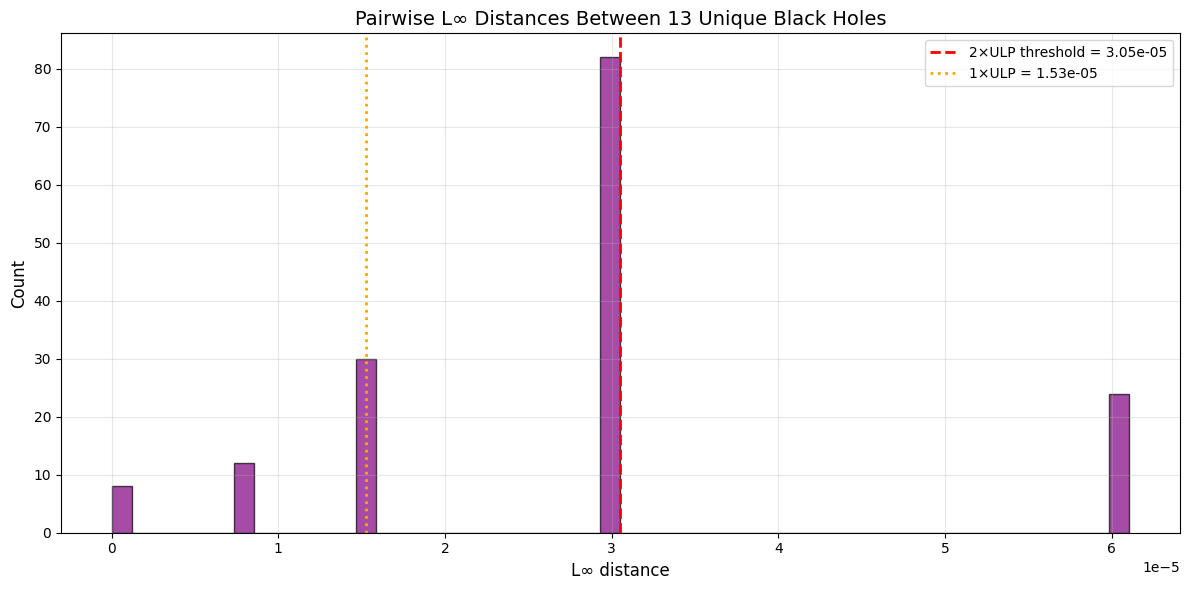

✓ Distance distribution plotted


In [14]:
if have_black_holes and n_unique > 1:
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
    
    ax.hist(l_inf_off_diag.cpu().numpy(), bins=50, alpha=0.7, 
            color='purple', edgecolor='black')
    
    # Mark threshold
    ax.axvline(threshold, color='red', linestyle='--', linewidth=2,
               label=f'2×ULP threshold = {threshold:.2e}')
    
    # Mark 1×ULP for reference
    ax.axvline(ulp, color='orange', linestyle=':', linewidth=2,
               label=f'1×ULP = {ulp:.2e}')
    
    ax.set_xlabel('L∞ distance', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Pairwise L∞ Distances Between {n_unique} Unique Black Holes', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Distance distribution plotted")

## Conclusion

We have now rigorously computed the quantum of separation for Qwen 3 4B Instruct 2507 vectors in bfloat16:

**Key findings:**
1. At the typical scale of embedding components (~10⁻³ to 10⁻²), ULP ≈ 3×10⁻⁵
2. The distinguishability threshold is **2×ULP** ≈ 6×10⁻⁵
3. Two vectors differing by less than this in all components are **quantization-indistinguishable**
4. The black hole structure (if loaded) validates this threshold

**Next steps:**
- 09.1b: Build adjacency graph using this threshold
- 09.1c: Analyze connected components and cluster structure
- 09.1d: Decode token IDs and semantic analysis